In [1]:
from IPython.display import Image
import os
import sys
os.chdir(r"/home/yuval/Documents/XNOR/sealnet-mlflow")

import cv2
from flow import s3_dataset, s3_cache
from noaadb import Session
from noaadb.schema.models import EOImage, HeaderMeta, IRLabelEntry, Species, IRImage, Flight
from flow.util import extract_util

red=[255,0,0]
orange=[255,165,0]
yellow=[255,255,0]
green=[0,255,0]
blue=[0,0,255]
indigo=[75,0,130]
violet=[238,130,238]
COLORS = [red,orange,yellow,green,blue,indigo,violet]

s = Session()


ir_norm_local_path = s3_dataset.get_dataset_local_path('normalized_ir')




/home/yuval/anaconda3/envs/sealnet/lib/python3.6/site-packages/sqlalchemy/util/langhelpers.py:225: SADeprecationWarning: The 'postgres' dialect name has been renamed to 'postgresql'
  loader = self.auto_fn(name)


In [2]:
import numpy as np

def plot_im(im):
    import matplotlib.pyplot as plt
    # load image using cv2....and do processing.
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(im,  cmap='gray', vmin=0, vmax=255)
    # as opencv loads in BGR format by default, we want to show it in RGB.
    plt.show()
    
# normalize IR
def min_max_norm(im):
    im_ir = ((im - np.min(im)) / (0.0 + np.max(im) - np.min(im)))
    im_ir = im_ir*255.0
    im_ir = im_ir.astype(np.uint8)
    print(im_ir.min(), im_ir.max())
    return im_ir

def standardize(im):
    mu = im.mean()
    std = im.std()
    im = (im-mu)/std
    im[im<0] = 0
    im = im*255.0
    return im

def percentile(im):
    mi = np.percentile( im, 1 )
    ma = np.percentile( im, 100 )
    normalized = ( im - mi ) / ( ma - mi )
    normalized = normalized * 255
    normalized[ normalized < 0 ] = 0
    return normalized
    
        



In [ ]:
        
im_obj = s.query(IRImage).filter(IRImage.file_name == 'polar_bear_2019_fl07_C_20190511_233032.965427_ir.tif').first()
im_obj = s.query(IRImage).filter(IRImage.file_name == 'polar_bear_2019_fl07_C_20190511_225112.837455_ir.tif').first()
im = cv2.imread(im_obj.file_path, cv2.IMREAD_ANYDEPTH)
print(im.min(), im.max())

im_norm = percentile(im)
plot_im(im_norm)


#### **functions**

In [3]:
# for every cam, in each flight, in eaech survey sample n images that contain a label (images with hotspots)
def sample_n_from_each_flight(n):
    fl_cam_dict = {}
    cams = extract_util.query_cfs(s,[],[],[])
    for cam in cams:
        if cam.cam_name == 'R':
            continue
        ir_images = s.query(IRImage).join(IRLabelEntry, IRLabelEntry.image_id == IRImage.file_name).join(HeaderMeta)\
            .filter(HeaderMeta.camera_id == cam.id).offset(100).limit(n).all()
        print(cam.flight.flight_name)
        fl_cam_dict[cam.flight.flight_name + '_' + cam.cam_name] = ir_images
    return fl_cam_dict

# draw ir boxes on a 1 channel image return 3 channel rgb
def draw_ir_boxes(im_1c, im_row):
    labels = s.query(IRLabelEntry).filter(IRLabelEntry.image_id == im_row.file_name).all()
    color = cv2.cvtColor(im_1c,cv2.COLOR_GRAY2RGB)
    for l in labels:
        print(l.to_dict())
        cv2.rectangle(color,(l.x1,l.y1),(l.x2,l.y2),(255,0,0),1)
    return color, labels
        
def save_ir_with_labels(im_1c, im_row):
    labels = s.query(IRLabelEntry).filter(IRLabelEntry.image_id == im_row.file_name).all()
    color = cv2.cvtColor(im_1c,cv2.COLOR_GRAY2RGB)
    for l in labels:
        print(l.to_dict())
        cv2.rectangle(color,(l.x1,l.y1),(l.x2,l.y2),(255,0,0),1)
    file_uri = s3_dataset.get_dataset_uri('normalized_ir/%s' % im_row.file_name.replace(".tif", ".jpg"))
    s3_dataset.save_image_local(color, file_uri)


# **Example IR Boxes experiment run**

In [ ]:
# Create a run to show some examples of normalized IR imagery with boxes
from flow import experiment, s3_cache, s3_dataset
import mlflow

IMS_PER_FLIGHT = 20
with mlflow.start_run(run_name='example_ir_boxes', experiment_id=experiment.experiment_id) as mlrun:
    mlflow.set_tag('method_fusion', True)
    mlflow.set_tag('data-source', 'noaadb')
    mlflow.set_tag('big_artifacts', True)

    # log the function used for normalization
    _, _ = s3_cache.log_function('normalization_function.txt', min_max_norm)


    mlflow.log_param('data_uri', s3_dataset.get_dataset_uri('normalized_ir'))
    mlflow.log_param('data_path', s3_dataset.get_dataset_local_path('normalized_ir'))

    s=Session()

    # get all IR images
    ims_per_flight = sample_n_from_each_flight(IMS_PER_FLIGHT)
    for k in ims_per_flight:
        for im_row in ims_per_flight[k]:
            im = cv2.imread(im_row.file_path, cv2.IMREAD_ANYDEPTH)
            print(im.min(), im.max())
            if im is None:
                issue_image_list.append(image.file_name)
                print('Issue:%s'%image.file_name)
                continue
            im_norm = min_max_norm(im)
            ir_with_boxes, labels = draw_ir_boxes(im_norm, im_row)
            
            uri = os.path.join(mlflow.get_artifact_uri(), k, im_row.file_name.replace(".tif", ".png"))
            s3_cache.save_image_local(ir_with_boxes, uri)
            mlflow.log_artifact(s3_cache.get_artifact_local_path(uri), k)
            
            label_list = [l.to_dict() for l in labels]
            uri = os.path.join(mlflow.get_artifact_uri(), k, im_row.file_name.replace(".tif", ".txt"))
            s3_cache.save_list_local(label_list, uri)
            mlflow.log_artifact(s3_cache.get_artifact_local_path(uri), k)
            
    if len(issue_image_list) > 0:
        uri = mlflow.get_artifact_uri('could_not_load_images.txt')
        local_path = s3_cache.save_list_local(issue_image_list, uri)
        mlflow.log_artifact(local_path)
    # end session
    s.close()

# **Basic blob detecetor**

In [7]:
# Create a run to show some examples of normalized IR imagery with boxes
from math import sqrt


def draw_keypoints(im, keypoints, color=(0,0,255)):
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), color, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return im_with_keypoints

def draw_labels(im, labels, color=(255,0,0)):
    for l in labels:
        im = cv2.rectangle(im,(l.x1,l.y1),(l.x2,l.y2),color,1)
    return im

def dist(labels, keypoints):
    n = len(labels)
    m = len(keypoints)
    dist_mat = np.zeros((n,m))
    for j, keypoint in enumerate(keypoints):
        k_cx = keypoint.pt[0]
        k_cy = keypoint.pt[1]
#         print(k_cx,k_cy)
        for i,label in enumerate(labels):
            l_cx = (label.x2 - label.x1)/2.0 + label.x1
            l_cy = (label.y2 - label.y1)/2.0 + label.y1
            dist = sqrt( (l_cx - k_cx)**2 + (l_cy - k_cy)**2)
            dist_mat[i,j] = dist
    
    return dist_mat

def dist_matches(dist_mat, labels, keypoints):
#     min_idxs = dist_mat.argmin(axis=1)
#     print(dist_mat[np.arange(len(min_idxs)), min_idxs])
    min_dist_from_box = dist_mat.min(axis=1)
    label_has_match = np.argwhere(min_dist_from_box<5).flatten()
    label_match = np.array(labels)[label_has_match]
    keypoint_idxs = dist_mat[label_has_match].argmin(axis=1)
    keypoint_match = np.array(keypoints)[keypoint_idxs]
    distances = dist_mat[label_has_match, keypoint_idxs]
    print(distances)
    pairs = list(zip(keypoint_match, label_match, distances))
    return pairs


def detect(im):
    params = cv2.SimpleBlobDetector_Params()
#     params.minThreshold = 2
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(cv2.bitwise_not(im))
    print('%d keypoints' % len(keypoints))
    return keypoints

def draw_all_kpts(im_name = 'polar_bear_2019_fl06_C_20190510_224452.841718_ir.tif'):
    # get image and labels
    im_row = s.query(IRImage).filter(IRImage.file_name == im_name).first()
    labels = s.query(IRLabelEntry).filter(IRLabelEntry.image_id == im_row.file_name).all()

    # load image, then normalize
    im = cv2.imread(im_row.file_path, cv2.IMREAD_ANYDEPTH)
    im_norm = min_max_norm(im)
    kpts = detect(im_norm)


    color_im = cv2.cvtColor(im_norm,cv2.COLOR_GRAY2RGB)
    
    color_im = draw_labels(color_im, labels)
    color_im = draw_keypoints(color_im, kpts)
    return kpts, labels, color_im

def blob_detect_match(im_name = 'polar_bear_2019_fl06_C_20190510_224452.841718_ir.tif'):
    # get image and labels
    im_row = s.query(IRImage).filter(IRImage.file_name == im_name).first()
    labels = s.query(IRLabelEntry).filter(IRLabelEntry.image_id == im_row.file_name).all()

    # load image, then normalize
    im = cv2.imread(im_row.file_path, cv2.IMREAD_ANYDEPTH)
#     print(im_row.file_path)
    
    im_norm = min_max_norm(im)
    kpts = detect(im_norm)
#     print(kpts)

    color_im = cv2.cvtColor(im_norm,cv2.COLOR_GRAY2RGB)

    if len(kpts) == 0:
        return color_im, []
    
    dists = dist(labels, kpts)
    pairs = dist_matches(dists, labels, kpts)
    for i,(k, l, d) in enumerate(pairs):
        draw_color = COLORS[i%len(COLORS)]
        cv2.putText(color_im,"%.3f"%d, (int(k.pt[0]), int(k.pt[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, draw_color, 1, cv2.LINE_AA)
        color_im = draw_labels(color_im, [l], color=draw_color)
        color_im = draw_keypoints(color_im, [k], color=draw_color)
    return color_im, pairs




0 255
1 keypoints


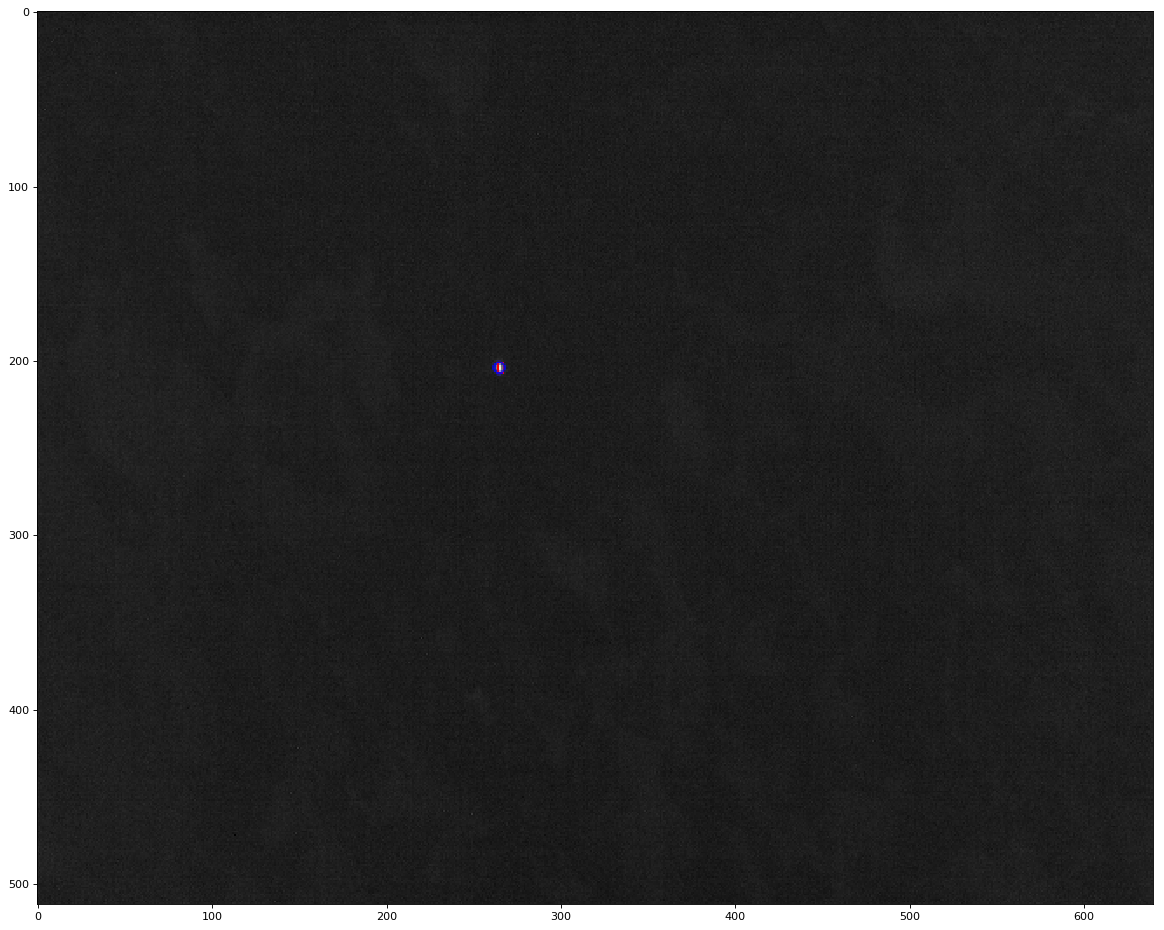

In [5]:
kpts, labels, im = draw_all_kpts(im_name = 'polar_bear_2019_fl07_L_20190512_004950.615818_ir.tif')
plot_im(im)

In [ ]:
# im, pairs = blob_detect_match(im_name = 'polar_bear_2019_fl07_L_20190512_004950.615818_ir.tif')


In [ ]:
from flow import experiment, s3_cache, s3_dataset
import mlflow
# kpts, labels, im = draw_all_kpts(im_name = 'polar_bear_2019_fl07_L_20190512_004950.615818_ir.tif')
# plot_im(im)
IMS_PER_FLIGHT = 10
with mlflow.start_run(run_name='example_blob_detect_match', experiment_id=experiment.experiment_id) as mlrun:
    mlflow.set_tag('method_fusion', True)
    mlflow.set_tag('data-source', 'noaadb')
    mlflow.set_tag('big_artifacts', True)

    # log the function used for normalization
    _, _ = s3_cache.log_functions('code.txt', [min_max_norm,draw_all_kpts,blob_detect_match,detect,dist_matches, dist,draw_labels,draw_keypoints])


    s=Session()

    # get all IR images
    ims_per_flight = sample_n_from_each_flight(IMS_PER_FLIGHT)
    for k in ims_per_flight:
        for im_row in ims_per_flight[k]:
            # detect blobs
            im, pairs = blob_detect_match(im_name = im_row.file_name)

            uri = os.path.join(mlflow.get_artifact_uri(), k, im_row.file_name.replace(".tif", "_matches.png"))
            s3_cache.save_image_local(im, uri)
            mlflow.log_artifact(s3_cache.get_artifact_local_path(uri), k)
            
            # draw all
            kpts, labels, im_all = draw_all_kpts(im_name = im_row.file_name)
            uri_all = os.path.join(mlflow.get_artifact_uri(), k, im_row.file_name.replace(".tif", "_all.jpg"))
            s3_cache.save_image_local(im_all, uri_all)
            mlflow.log_artifact(s3_cache.get_artifact_local_path(uri_all), k)
            
            label_list = [l.to_dict() for l in labels]
            uri = os.path.join(mlflow.get_artifact_uri(), k, im_row.file_name.replace(".tif", ".txt"))
            s3_cache.save_list_local(label_list, uri)
            mlflow.log_artifact(s3_cache.get_artifact_local_path(uri), k)

    # end session
    s.close()

In [ ]:

dir_path = os.path.dirname(sys.argv[0])
print(dir_path)